# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク1

## Sprintの目的
スクラッチを通してCNNの基礎を理解する

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, *shape):
        """
        重みの初期化
        Parameters
        ----------

        Returns
        ----------
        W : (n_nodes1, n_nodes2,)
        W : (n_in_channels, n_out_channels, filter_size,)
        """
        W = self.sigma * np.random.randn(*shape)
        return W
    def B(self, *shape):
        """
        バイアスの初期化
        Parameters
        ----------

        Returns
        ----------
        B : (n_out_channels,)
        B : (n_nodes2,)
        """
        B = self.sigma * np.random.randn(*shape)
        return B

In [4]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return

class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB

## 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成

In [12]:
class SimpleConv1d:
    
    def __init__(self, filter_size, initializer, optimizer, pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(filter_size)
        self.B = initializer.B(1)[0]
        self.n_out = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_out)
            出力
        """
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa)
        """
        self.X = np.pad(X, self.pa)
        A = np.zeros(self.n_out)
        for i in range(self.n_out):
            for s in range(self.filter_size):
                A[i] += self.X[i+s]*self.W[s]
            A[i] += self.B
        #"""
        #""
        self.X = np.pad(X, ((self.filter_size-1), 0))
        self.X1 = np.zeros((self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[i] = np.roll(self.X, -i)
        A = self.W@self.X1[:, self.filter_size-1-self.pa:self.n_in+self.pa] + self.B
        #"""
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (n_out)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (n_in)
            前に流す勾配
        """
        """
        self.dW = np.zeros(self.W.shape)
        self.dB = 0
        for s in range(self.filter_size):
            for i in range(self.n_out):
                self.dW[s] += dA[i]*self.X[i+s]
        for i in range(self.n_out):
            self.dB += dA[i]
        dX = np.zeros(self.X.shape)
        for j in range(self.n_in):
            for s in range(self.filter_size):
                if 0 <= j-s <= self.n_out-1:
                    dX[j] += dA[j-s]*self.W[s]
        """
        #"""
        self.dW = self.X1[:, self.filter_size-1-self.pa:self.n_in+self.pa]@dA
        self.dB = np.sum(dA)
        self.dA = np.pad(dA, (0, (self.filter_size-1)))
        self.dA1 = np.zeros((self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[i] = np.roll(self.dA, i)
        dX = self.W@self.dA1
        #"""
        
        self.optimizer.update(self)
        return dX

## 【問題2】1次元畳み込み後の出力サイズの計算

In [13]:
def out_size(in_size, f, p=0, s=1):
    return int((in_size+2*p-f) // s) + 1

## 【問題3】小さな配列での1次元畳み込み層の実験

In [14]:
simple_conv1d = SimpleConv1d(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), pa=0)

In [15]:
x = np.array([1,2,3,4])
simple_conv1d.W = np.array([3, 5, 7], dtype=float)
simple_conv1d.B = np.array([1], dtype=float)

In [16]:
a = simple_conv1d.forward(x)
a

array([35., 50.])

In [17]:
delta_a = np.array([10, 20])
delta_x = simple_conv1d.backward(delta_a)
delta_x

array([ 30., 110., 170., 140.])

In [18]:
delta_w = simple_conv1d.dW
delta_b = simple_conv1d.dB
delta_w, delta_b

(array([ 50.,  80., 110.]), 30)

## 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成

In [20]:
class Conv1d:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_in_channels, n_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_out_channels, n_out)
            出力
        """
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa)
        X = X.reshape(self.n_in_channels, self.n_in)
        """
        self.X = np.pad(X, ((0,0),(self.pa,self.pa)))
        A = np.zeros((self.n_out_channels, self.n_out))
        for k in range(self.n_out_channels):
            for i in range(self.n_out):
                for m in range(self.n_in_channels):
                    for s in range(self.filter_size):
                        A[k, i] += self.X[m, i+s]*self.W[k, m, s]
                A[k, i] += self.B[k]
        #"""
        #""
        self.X = np.pad(X, ((0,0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, :, self.filter_size-1-self.pa:self.n_in+self.pa]*self.W[:, :, :, np.newaxis], axis=(1, 2)) + self.B.reshape(-1,1)
        #"""
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (n_out_channels, n_out)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (n_in_channels, n_in)
            前に流す勾配
        """
        """
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        for k in range(self.n_out_channels):
            for i in range(self.n_out):
                for m in range(self.n_in_channels):
                    for s in range(self.filter_size):
                        self.dW[k, m, s] += dA[k, i]*self.X[m, i+s]
                self.dB[k] += dA[k, i]
        dX = np.zeros((self.n_in_channels, self.n_in))
        for m in range(self.n_in_channels):
            for j in range(self.n_in):
                for k in range(self.n_out_channels):
                    for s in range(self.filter_size):
                        if 0 <= j-s <= self.n_out-1:
                            dX[m, j] += dA[k, j-s]*self.W[k, m, s]
        #"""
        #"""
        self.dW = np.sum(np.dot(dA, self.X1[:, :, self.filter_size-1-self.pa:self.n_in+self.pa, np.newaxis]), axis=-1)
        self.dB = np.sum(dA, axis=1)
        self.dA = np.pad(dA, ((0,0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W@self.dA1, axis=0)
        #"""
        self.optimizer.update(self)
        return dX

In [21]:
conv1d = Conv1d(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=2, n_out_channels=3, pa=0)

In [22]:
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
conv1d.W = np.ones((3, 2, 3), dtype=float) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
#"""
conv1d.W[0,0,2] = 2
conv1d.W[0,1,0] = 2
conv1d.W[1,0,0] = 2
#"""
conv1d.B = np.array([1, 2, 3], dtype=float) # （出力チャンネル数）
conv1d.W

array([[[1., 1., 2.],
        [2., 1., 1.]],

       [[2., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [23]:
a = conv1d.forward(x)
a

array([[21., 29.],
       [18., 25.],
       [18., 24.]])

In [24]:
delta_a = np.array([[9, 11], [32, 35], [52, 56]])
delta_x = conv1d.backward(delta_a)
delta_x

array([[125., 230., 204., 113.],
       [102., 206., 195., 102.]])

In [25]:
delta_w = conv1d.dW
delta_b = conv1d.dB
delta_w, delta_b

(array([[[ 31.,  51.,  71.],
         [ 51.,  71.,  91.]],
 
        [[102., 169., 236.],
         [169., 236., 303.]],
 
        [[164., 272., 380.],
         [272., 380., 488.]]]), array([ 20,  67, 108]))

## 【問題5】（アドバンス課題）パディングの実装

SimpleConv1d クラスと Conv1d クラスを変更

## 【問題6】（アドバンス課題）ミニバッチへの対応

In [27]:
class Conv1d_2:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_in_channels, n_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, n_out_channels, n_out)
            出力
        """
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        """
        self.X = np.pad(X, ((0,0),(0,0),(self.pa,self.pa)))
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out))
        for t in range(self.n_samples):
            for k in range(self.n_out_channels):
                for i in range(self.n_out):
                    for m in range(self.n_in_channels):
                        for s in range(self.filter_size):
                            A[t, k, i] += self.X[t, m, i+s]*self.W[k, m, s]
                    A[t, k, i] += self.B[k]
        #"""
        #"""
        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        #"""
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (n_samples, n_out_channels, n_out)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (n_samples, n_in_channels, n_in)
            前に流す勾配
        """
        """
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        for t in range(self.n_samples):
            for k in range(self.n_out_channels):
                for i in range(self.n_out):
                    for m in range(self.n_in_channels):
                        for s in range(self.filter_size):
                            self.dW[k, m, s] += dA[t, k, i]*self.X[t, m, i+s]
                    self.dB[k] += dA[t, k, i]
        dX = np.zeros((self.n_samples, self.n_in_channels, self.n_in))
        for t in range(self.n_samples):
            for m in range(self.n_in_channels):
                for j in range(self.n_in):
                    for k in range(self.n_out_channels):
                        for s in range(self.filter_size):
                            if 0 <= j-s <= self.n_out-1:
                                dX[t, m, j] += dA[t, k, j-s]*self.W[k, m, s]
        #"""
        #"""
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        #"""
        self.optimizer.update(self)
        return dX

In [28]:
conv1d_2 = Conv1d_2(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=1, n_out_channels=1, pa=1)

In [29]:
x = np.array([[[1,5,0,2,8,1]], [[1,5,0,2,8,1]]])
conv1d_2.W = np.array([[[-1, 2, -1]]], dtype=float)
conv1d_2.B = np.array([0], dtype=float)

In [30]:
a = conv1d_2.forward(x)
a

array([[[-3.,  9., -7., -4., 13., -6.]],

       [[-3.,  9., -7., -4., 13., -6.]]])

In [31]:
delta_a = np.array([[[1,2,3,4,5,6]], [[1,2,3,4,5,6]]])
delta_x = conv1d_2.backward(delta_a)
delta_x

array([[[-1.,  0.,  0.,  0.,  0.,  0.,  7., -6.]],

       [[-1.,  0.,  0.,  0.,  0.,  0.,  7., -6.]]])

In [32]:
delta_w = conv1d_2.dW
delta_b = conv1d_2.dB
delta_w, delta_b

(array([[[150., 130.,  96.]]]), array([42]))

In [33]:
conv1d_2 = Conv1d_2(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=2, n_out_channels=3, pa=0)

In [34]:
x = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
conv1d_2.W = np.ones((3, 2, 3), dtype=float) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
#"""
conv1d_2.W[0,0,2] = 2
conv1d_2.W[0,1,0] = 2
conv1d_2.W[1,0,0] = 2
#"""
conv1d_2.B = np.array([1, 2, 3], dtype=float) # （出力チャンネル数）
conv1d_2.W

array([[[1., 1., 2.],
        [2., 1., 1.]],

       [[2., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.]]])

In [35]:
a = conv1d_2.forward(x)
a

array([[[21., 29.],
        [18., 25.],
        [18., 24.]]])

In [36]:
delta_a = np.array([[[9, 11], [32, 35], [52, 56]]])
delta_x = conv1d_2.backward(delta_a)
delta_x

array([[[125., 230., 204., 113.],
        [102., 206., 195., 102.]]])

In [37]:
delta_w = conv1d_2.dW
delta_b = conv1d_2.dB
delta_w, delta_b

(array([[[ 31.,  51.,  71.],
         [ 51.,  71.,  91.]],
 
        [[102., 169., 236.],
         [169., 236., 303.]],
 
        [[164., 272., 380.],
         [272., 380., 488.]]]), array([ 20,  67, 108]))

## 【問題7】（アドバンス課題）任意のストライド数

In [39]:
class Conv1d_3:
    
    def __init__(self, filter_size, initializer, optimizer, n_in_channels=1, n_out_channels=1, pa=0, st=1):
        self.filter_size = filter_size
        self.optimizer = optimizer
        self.pa = pa
        self.st = st
        self.W = initializer.W(n_out_channels, n_in_channels, filter_size)
        self.B = initializer.B(n_out_channels)
        self.n_in_channels = n_in_channels
        self.n_out_channels = n_out_channels
        self.n_out = None
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_in_channels, n_in)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (n_samples, n_out_channels, n_out)
            出力
        """
        self.n_samples = X.shape[0]
        self.n_in = X.shape[-1]
        self.n_out = out_size(self.n_in, self.filter_size, self.pa, self.st)
        X = X.reshape(self.n_samples, self.n_in_channels, self.n_in)
        """
        self.X = np.pad(X, ((0,0),(0,0),(self.pa,self.pa)))
        A = np.zeros((self.n_samples, self.n_out_channels, self.n_out))
        for t in range(self.n_samples):
            for k in range(self.n_out_channels):
                for i in range(self.n_out):
                    for m in range(self.n_in_channels):
                        for s in range(self.filter_size):
                            A[t, k, i] += self.X[t, m, i*self.st+s]*self.W[k, m, s]
                    A[t, k, i] += self.B[k]
        #"""
        #"""
        self.X = np.pad(X, ((0,0), (0,0), ((self.filter_size-1), 0)))
        self.X1 = np.zeros((self.n_samples, self.n_in_channels, self.filter_size, self.n_in+(self.filter_size-1)))
        for i in range(self.filter_size):
            self.X1[:, :, i] = np.roll(self.X, -i, axis=-1)
        A = np.sum(self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st]*self.W[:, :, :, np.newaxis], axis=(2, 3)) + self.B.reshape(-1,1)
        #"""
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (n_samples, n_out_channels, n_out)
            後ろから流れてきた勾配
        Returns
        ----------
        dX : 次の形のndarray, shape (n_samples, n_in_channels, n_in)
            前に流す勾配
        """
        """
        self.dW = np.zeros(self.W.shape)
        self.dB = np.zeros(self.B.shape)
        for t in range(self.n_samples):
            for k in range(self.n_out_channels):
                for i in range(self.n_out):
                    for m in range(self.n_in_channels):
                        for s in range(self.filter_size):
                            self.dW[k, m, s] += dA[t, k, i]*self.X[t, m, i*self.st+s]
                    self.dB[k] += dA[t, k, i]
        dX = np.zeros((self.n_samples, self.n_in_channels, self.n_in))
        for t in range(self.n_samples):
            for m in range(self.n_in_channels):
                for j in range(self.n_in):
                    for k in range(self.n_out_channels):
                        for s in range(self.filter_size):
                            if 0 <= j-s <= self.n_out-1:
                                dX[t, m, j] += dA[t, k, j-s]*self.W[k, m, s]
        #"""
        #"""
        self.dW = np.sum(dA[:, :, np.newaxis, np.newaxis]*self.X1[:, np.newaxis, :, :, self.filter_size-1-self.pa:self.n_in+self.pa:self.st], axis=(0, -1))
        self.dB = np.sum(dA, axis=(0, -1))
        self.dA = np.pad(dA, ((0,0), (0,0), (0, (self.filter_size-1))))
        self.dA1 = np.zeros((self.n_samples, self.n_out_channels, self.filter_size, self.dA.shape[-1]))
        for i in range(self.filter_size):
            self.dA1[:, :, i] = np.roll(self.dA, i, axis=-1)
        dX = np.sum(self.W[:, :, :, np.newaxis]*self.dA1[:, :, np.newaxis], axis=(1,3))
        #"""
        self.optimizer.update(self)
        return dX

In [40]:
conv1d_3 = Conv1d_3(filter_size=3, initializer=SimpleInitializer(0.01), optimizer=SGD(0.01), n_in_channels=1, n_out_channels=1, pa=1, st=2)

In [41]:
x = np.array([[[1,5,0,2,8,1]]])
conv1d_3.W = np.array([[[-1, 2, -1]]], dtype=float)
conv1d_3.B = np.array([0], dtype=float)

In [42]:
a = conv1d_3.forward(x)
a

array([[[-3., -7., 13.]]])

In [43]:
delta_a = np.array([[[1,2,3]]])
delta_x = conv1d_3.backward(delta_a)
delta_x

array([[[-1.,  0.,  0.,  4., -3.]]])

In [44]:
delta_w = conv1d_3.dW
delta_b = conv1d_3.dB
delta_w, delta_b

(array([[[16., 25., 12.]]]), array([6]))

## 【問題8】学習と推定

In [45]:
class ActSigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ):
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

class ActTanh:
    
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        return dZ * (1 - (np.tanh(self.A))**2)

class ActSoftmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    
    def backward(self, Y):
        self.loss = self.loss_func(Y)
        return self.Z - Y
    
    def loss_func(self, Y, Z=None):
        """
        y_true : (n_samples, n_output)
        z : (n_samples, n_output)
        """
        if Z is None:
            Z = self.Z
        return (-1)*np.average(np.sum(Y*np.log(Z), axis=1))

class ActReLU:
    def forward(self, A):
        self.A = A
        return np.clip(A, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.A), 0, None)

class ScratchConvNeuralNetrowkClassifier:
    
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, 
                 n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                 verbose=True, Activater=ActTanh, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        # self.n_nodes1 = n_nodes1 # 1層目のノード数 # self.conv1d_3.n_out になる
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        
        self.Activater = Activater
        if Activater == ActSigmoid or Activater == ActTanh:
            self.Initializer = XavierInitializer
        elif Activater == ActReLU:
            self.Initializer = HeInitializer
        else:
            print("活性化関数が不適切")
        self.Optimizer = Optimizer
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
        #optimizer = self.Optimizer(self.lr)
        self.conv1d_3 = Conv1d_3(filter_size=7, initializer=SimpleInitializer(0.01), optimizer=self.Optimizer(self.lr), n_in_channels=1, n_out_channels=1, pa=3, st=2)
        self.conv1d_3.n_out = out_size(X.shape[-1], self.conv1d_3.filter_size, self.conv1d_3.pa, self.conv1d_3.st)
        self.activation1 = self.Activater()
        self.FC2 = FC(1*self.conv1d_3.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = ActSoftmax()
        
        self.loss = []
        self.loss_epoch = [self.activation3.loss_func(y, self.forward_propagation(X))]
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            self.iter = len(get_mini_batch)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
                self.loss.append(self.activation3.loss)
            self.loss_epoch.append(self.activation3.loss_func(y, self.forward_propagation(X)))
        
        if self.verbose:
            self.learning_curve()
            print()
        
    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def forward_propagation(self, X):
        A1 = self.conv1d_3.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
        
    def back_propagation(self, X, y_true):
        dA3 = self.activation3.backward(y_true) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]
        dZ0 = self.conv1d_3.backward(dA1) # dZ0は使用しない
    
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(1, self.num_epoch*self.iter + 1), self.loss, label="train_loss")
        plt.plot(np.arange(0, self.num_epoch + 1)*self.iter, self.loss_epoch, label="epoch_loss")
        if self.val_enable:
            plt.plot(np.arange(1, self.num_epoch + 1), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()
        return

class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = X@self.W + self.B
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = dA@self.W.T
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

class XavierInitializer:
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B
    
class HeInitializer():
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [46]:
def evaluate(y_true, y_pred):
    print("accuracy =", accuracy_score(y_true, y_pred))
    print("precision =", precision_score(y_true, y_pred, average='macro'))
    print("recall =", recall_score(y_true, y_pred, average='macro'))
    print("f1 =", f1_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))

## データ

In [47]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### データセットの確認

In [48]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


### 平滑化

In [49]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

### 画像データの可視化

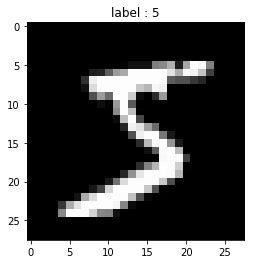

In [50]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

### 前処理

In [51]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [52]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [53]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train.shape =", X_train_.shape) # (48000, 784)
print("X_val.shape =", X_val.shape) # (12000, 784)
print("y_train.shape =", y_train_.shape) # (48000, 784)
print("y_val.shape =", y_val.shape) # (12000, 784)

X_train.shape = (48000, 784)
X_val.shape = (12000, 784)
y_train.shape = (48000, 10)
y_val.shape = (12000, 10)


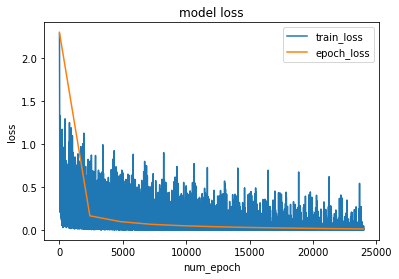

In [54]:
scratch_cnn1 = ScratchConvNeuralNetrowkClassifier(num_epoch=10, lr=0.01, batch_size=20, 
                                                  n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, 
                                                  verbose=True, Activater=ActTanh, Optimizer=SGD)
scratch_cnn1.fit(X_train_, y_train_)

In [55]:
y_pred1 = scratch_cnn1.predict(X_test)

In [56]:
evaluate(y_test, y_pred1)

accuracy = 0.9747
precision = 0.974718099185355
recall = 0.9745732753488368
f1 = 0.9745810852271621
[[ 973    0    0    1    0    1    4    1    0    0]
 [   0 1120    3    2    0    1    4    2    3    0]
 [   8    2 1000    8    1    0    4    6    2    1]
 [   0    0    2  993    0    5    0    4    3    3]
 [   1    0    1    0  951    0    4    1    0   24]
 [   2    0    0    9    0  870    4    1    4    2]
 [   5    3    0    0    4    4  942    0    0    0]
 [   2    4    9    4    1    0    0 1001    2    5]
 [   5    1    4   14    4    5    7    2  928    4]
 [   2    5    0    8    9    3    1   11    1  969]]
